In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
os.chdir("/content/drive/My Drive/Etudes/Sup/Mobilité/NTNU/Cours/SPRING/DL/Project 3/VAEKeras3")

## Data & parameters

In [7]:
import keras
from keras import layers

import numpy as np

from modules.layers    import SamplingLayer, VariationalLossLayer


'''import sys'''


from stacked_mnist import StackedMNISTData, DataMode
from verification_net import *


In [8]:
from Classifier import * #à améliorer pour ne pas re run le modèle à chaque fois (juste load les weights)


782/782 [==============================] - 21s 27ms/step
Coverage: 100.00%
Predictability: 100.00%
Accuracy: 98.58%


In [9]:
latent_dim    = 20
loss_weights  = [1,.06]

seed          = 123

batch_size    = 64
epochs        = 5
fit_verbosity = 1

In [10]:
generator = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = generator.get_full_data_set(training=True)
x_test, y_test = generator.get_full_data_set(training=False)

#only look at one channel to train the model
x_train_R = x_train[:, :, :, [0]]
x_test_R = x_test[:, :, :, [0]]

## Model Def

#### Encoder

In [11]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(32, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

#### Decoder

In [12]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

# decoder.summary()

VAE

In [13]:
inputs = keras.Input(shape=(28, 28, 1))

z_mean, z_log_var, z = encoder(inputs)
outputs              = decoder(z)

outputs = VariationalLossLayer(loss_weights=loss_weights)([inputs, z_mean, z_log_var, outputs])

#First VAE
vae=keras.Model(inputs,outputs)
vae.compile(optimizer='adam', loss=None)

### Train & Perf


In [14]:
history = vae.fit(x_train_R, epochs=epochs, batch_size=batch_size, verbose=fit_verbosity)


Epoch 1/5
938/938 [==============================] - 200s 209ms/step - loss: 132.5788
Epoch 2/5
938/938 [==============================] - 196s 209ms/step - loss: 86.3125
Epoch 3/5
938/938 [==============================] - 201s 215ms/step - loss: 76.5532
Epoch 4/5
938/938 [==============================] - 193s 206ms/step - loss: 69.1069
Epoch 5/5
938/938 [==============================] - 195s 208ms/step - loss: 65.7530


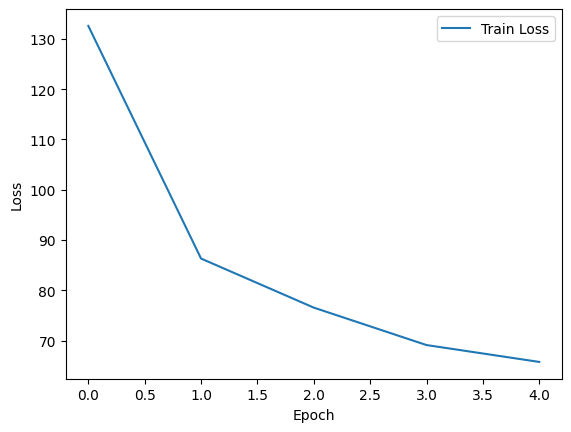

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
no_channels = x_test.shape[-1]

data_gen = np.zeros(x_test.shape)
for channel in range(no_channels):
    data = vae.predict(x_test[:, :, :, [channel]])
    data_gen[:, :, :, channel] = data.squeeze()  # squeeze() to delete 1 dimension

313/313 [==============================] - 12s 37ms/step


In [17]:
data_gen.shape #images generated by vae

(10000, 28, 28, 3)

In [18]:
predictions, beliefs = net.predict(data_gen)

313/313 [==============================] - 10s 30ms/step


In [19]:
predictions

array([163., 131., 684., ...,  30.,  70., 698.])

In [20]:
np.mean(predictions == y_test)

0.835

In [21]:
net.check_predictability(data = data_gen, correct_labels=y_test, tolerance=0.5)

313/313 [==============================] - 10s 31ms/step


(0.9319, 0.8128)

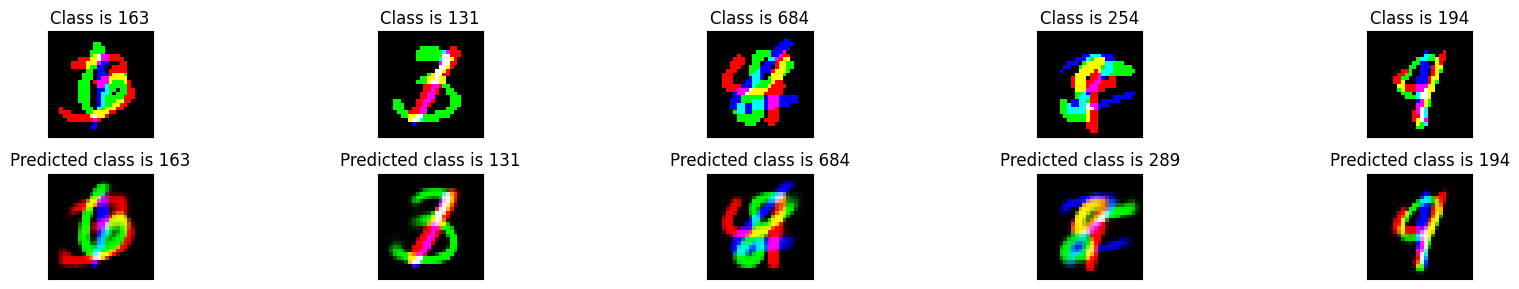

In [22]:
images = np.concatenate((x_test[:5], data_gen[:5]))
labels = np.concatenate((y_test[:5], predictions[:5]))

no_images = images.shape[0]

plt.figure(figsize=(18, 3))
no_rows = 2
no_cols = no_images//2
for img_idx in range(no_images):
    plt.subplot(int(no_rows), int(no_cols), img_idx + 1)
    if x_test.shape[-1] == 1:
        plt.imshow(images[img_idx, :, :, 0], cmap="binary")
    else:
        plt.imshow(images[img_idx, :, :, :].astype(float))
    plt.xticks([])
    plt.yticks([])
    if img_idx < no_images//2:
        plt.title(f"Class is {str(int(labels[img_idx])).zfill(x_test.shape[-1])}")
    else :
        plt.title(f"Predicted class is {str(int(labels[img_idx])).zfill(x_test.shape[-1])}")
# Show the thing ...
plt.tight_layout()
plt.show()

## Generative

In [41]:
mode = 'MONO'

data_size = 9

random_vectors = np.random.randn(data_size, latent_dim)

In [42]:
img_gen = decoder.predict(random_vectors)

1/1 [==============================] - 0s 37ms/step


In [25]:
if mode == 'COLOR' :
    # Séparer img_gen en 3 groupes
    group1, group2, group3 = np.split(img_gen, 3)

    # Concaténer les groupes en une seule matrice
    concatenated_img = np.concatenate((group1, group2, group3), axis=3)
    concatenated_img.shape

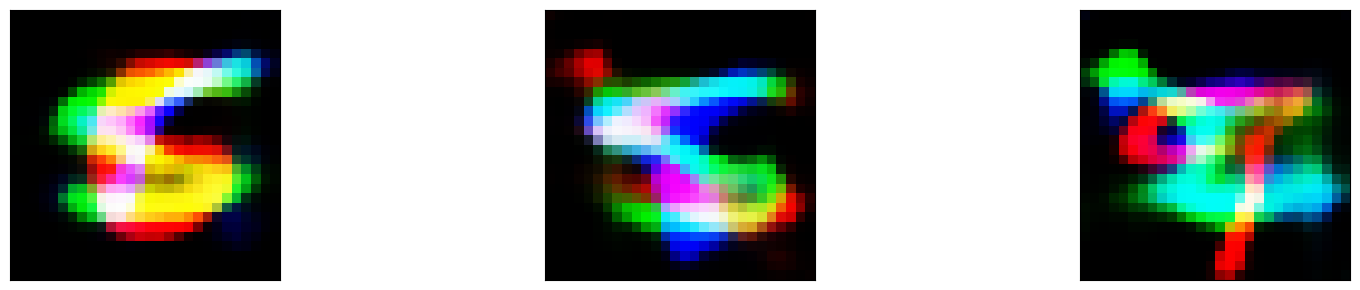

In [26]:
if mode == 'COLOR':
    images = concatenated_img

    no_images = images.shape[0]

    plt.figure(figsize=(18, 3))
    no_rows = 1
    no_cols = no_images
    for img_idx in range(no_images):
        plt.subplot(int(no_rows), int(no_cols), img_idx + 1)
        plt.imshow(images[img_idx, :, :, :].astype(float))
        plt.xticks([])
        plt.yticks([])
    # Show the thing ...
    plt.tight_layout()
    plt.show()

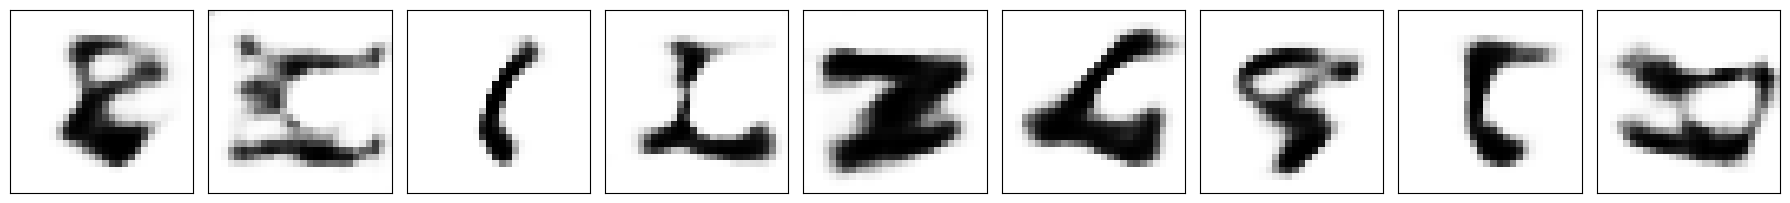

In [43]:
if mode == 'MONO':
    images = img_gen

    no_images = images.shape[0]

    plt.figure(figsize=(18, 3))
    no_rows = 1
    no_cols = no_images
    for img_idx in range(no_images):
        plt.subplot(int(no_rows), int(no_cols), img_idx + 1)
        plt.imshow(images[img_idx, :, :, 0], cmap="binary")
        plt.xticks([])
        plt.yticks([])
    # Show the thing ...
    plt.tight_layout()
    plt.show()

## Anomally

In [28]:
#Pour chaque exemple :
  #Faire passer dans l'encodeur
  #Générer 10000 exemples dans la densité de proba créée
  #Calucler la binary cross négative et élevée à l'exponentielle pour avoir les probas
  #Chopper les probas les plus faibles

In [29]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(32, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder_anom = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

In [30]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder_anom = keras.Model(inputs, outputs, name="decoder")

# decoder.summary()

In [31]:
inputs = keras.Input(shape=(28, 28, 1))

z_mean, z_log_var, z = encoder_anom(inputs)
outputs              = decoder_anom(z)

outputs = VariationalLossLayer(loss_weights=loss_weights)([inputs, z_mean, z_log_var, outputs])

#VAE for anomally, trained on the incomplete dataset
vae_anom=keras.Model(inputs,outputs)
vae_anom.compile(optimizer='adam', loss=None)

In [32]:
#Train on missing Data

anomaly_data = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train_anom, y_train_anom = anomaly_data.get_full_data_set(training=True)
x_test_anom, y_test_anom = anomaly_data.get_full_data_set(training=False)

#only look at one channel to train the model
x_train_anom_R = x_train_anom[:, :, :, [0]]
x_test_anom_R = x_test_anom[:, :, :, [0]]

In [33]:
full_data = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = full_data.get_full_data_set(training=True)
x_test, y_test = full_data.get_full_data_set(training=False)

#only look at one channel to train the model
x_train_R = x_train[:, :, :, [0]]
x_test_R = x_test[:, :, :, [0]]

In [34]:
history = vae_anom.fit(x_train_anom_R, x_train_anom_R,
                 batch_size      = batch_size,
                 epochs          = 3,
                 verbose         = fit_verbosity,
                 validation_data = (x_test_anom_R, x_test_anom_R),
)

Epoch 1/3
847/847 [==============================] - 186s 215ms/step - loss: 126.5444 - val_loss: 80.9709
Epoch 2/3
847/847 [==============================] - 188s 223ms/step - loss: 66.3928 - val_loss: 71.0504
Epoch 3/3
847/847 [==============================] - 180s 212ms/step - loss: 58.8996 - val_loss: 64.4191


In [37]:
# Test on all data and check loss for each data

#from keras.losses import binary_crossentropy

# Prédire avec l'autoencodeur
no_channels = x_test.shape[-1]

reconstructions = np.zeros(x_test.shape)
for channel in range(no_channels):
    z_mean, z_log_var, z = encoder_anom.predict(x_test[:, :, :, [channel]])
    random_vectors = np.random.randn(10, x_test.shape[0], latent_dim)*np.expand_dims(z_log_var, axis = 2) + z_mean
    data = decoder_anom.predict(random_vectors)




313/313 [==============================] - 6s 19ms/step


ValueError: operands could not be broadcast together with shapes (10,10000,20) (10000,20,1) 

In [ ]:
print(f'data shape {data.shape}')
print(f'x_test shape {x_test.shape}')

In [ ]:
z_mean.shape

In [ ]:
for output in data :
  output
